# Polyphonic Pitch Detection

Multiheaded model for polyphonic pitch detection.

In [1]:
%matplotlib inline

# Setup autoreload for local modules, otherwise Jupyter caches modules
# on first load. Add new local modules here if necessary.
%load_ext autoreload
%autoreload 2
%aimport deepsamples, helpers, gen_chord_samples, gen_note_samples

# To use specific version
# %pip install --user tensorflow==2.1

Using TensorFlow backend.


# Generate Samples (Option 1)

Download dependencies and generate samples here. Alternatively you can download the pre-generated samples from the next step.

In [ ]:
# Onetime Setup
%pip install midiutil
!sudo apt-get -y install sox fluidsynth
!wget --no-check-certificate https://muthanna.com/deepears/soundfont.sf2

In [7]:
!rm -rf samples
!mkdir -p samples
from gen_chord_samples import gen_polyphonic_samples

from IPython.utils import io

gen_polyphonic_samples(1000)

[============================================================] 1000/1000

In [11]:
!find samples | wc -l
!sox --i samples/A2-P0-minor-i0-110.000-S0-V0.29-noreject-attack.wav

14996
sox FAIL formats: can't open input file `samples/A2-P0-minor-i0-110.000-S0-V0.29-noreject-attack.wav': No such file or directory


### Upload samples to Storage Bucket

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [9]:
!rm samples.zip; zip -q -r samples.zip samples
!ls -lh samples.zip

-rw-r--r-- 1 jupyter jupyter 389M Mar 18 13:25 samples.zip


In [10]:
!gsutil -h "Cache-control:public,max-age=86400" -m cp -a public-read samples.zip gs://muthanna.com/deepears/poly-samples-v1.zip

[autoreload of deepsamples failed: Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/opt/conda/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/opt/conda/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/jupyter/deepears/deepsamples.py", line 15, in <module>
    from midi import Notes
ImportError: cannot import name 'Notes' from 'midi' (/home/jupyter/deepears/midi.py)
]


Copying file://samples.zip [Content-Type=application/zip]...
\ [1/1 files][388.2 MiB/388.2 MiB] 100% Done                                    
Operation completed over 1 objects/388.2 MiB.                                    


# Download Samples (Option 2)

In [12]:
!wget --no-check-certificate https://muthanna.com/deepears/poly-samples-v1.zip
!rm -rf samples
!unzip -q poly-samples-v1.zip
!ls -l samples/ | wc -l
!ls -l samples | head

--2020-03-18 13:31:50--  https://muthanna.com/deepears/poly-samples-v1.zip
Resolving muthanna.com (muthanna.com)... 35.244.227.152
Connecting to muthanna.com (muthanna.com)|35.244.227.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407010587 (388M) [application/zip]
Saving to: ‘poly-samples-v1.zip’

poly-samples-v1.zip 100%[===================>] 388.16M  57.9MB/s    in 6.6s    

2020-03-18 13:31:57 (58.9 MB/s) - ‘poly-samples-v1.zip’ saved [407010587/407010587]

14996
total 479840
-rw-r--r-- 1 jupyter jupyter 32044 Mar 18 13:12 poly--P0-N:A2-425.000-S-15-V0.43-noreject-full.wav
-rw-r--r-- 1 jupyter jupyter 32044 Mar 18 13:08 poly--P0-N:A2-440.000-S0-V0.25-noreject-full.wav
-rw-r--r-- 1 jupyter jupyter 32044 Mar 18 13:12 poly--P0-N:A2-440.000-S0-V0.94-noreject-full.wav
-rw-r--r-- 1 jupyter jupyter 32044 Mar 18 13:08 poly--P0-N:A2-448.000-S8-V0.98-noreject-full.wav
-rw-r--r-- 1 jupyter jupyter 32044 Mar 18 13:08 poly--P0-N:A2-453.000-S13-V0.44-noreject-full.

# Config and Setup

In [2]:
import os
files = os.listdir("samples")
print(len(files))
print(("\n").join(files[:5]))

14995
poly--P56-N:Cs3:E3:B2:C4:G6:Gs3-416.000-S-24-V0.42-noreject-full.wav
poly--P26-N:Cs2-464.000-S24-V0.63-noreject-full.wav
poly--P48-N:F5:G3-419.000-S-21-V0.78-noreject-full.wav
poly--P66-N:F4-412.000-S-28-V0.76-noreject-full.wav
poly--P78-N:G4:Cs5:G2:Fs6:G5-439.000-S-1-V0.75-noreject-full.wav


In [3]:
import numpy as np
from scipy.io import wavfile
from scipy import signal
import matplotlib
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from IPython import display

import helpers
from helpers import Config
from deepsamples import PolySamples

Spectrogram for samples/poly--P3-N:C3:B4-440.000-S0-V0.25-noreject-full.wav
(513, 59)


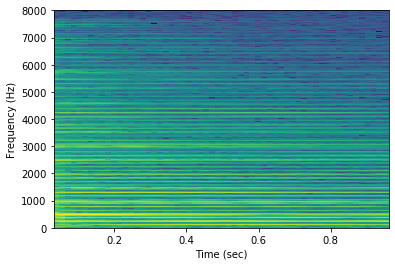

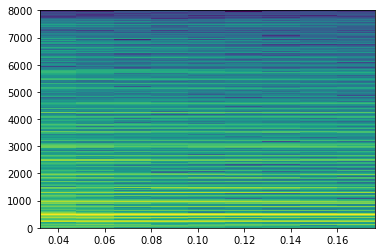

In [5]:
import os
import random

config = Config(
    rows=513,
    cols = 59,
    s_nperseg = 1024,
    s_nfft = 1024,
    s_noverlap = 768,
    log_scale = True,
    clip_magnitude_quantile=0.25,
    resample = 16000)

f, t, Sxx = helpers.spectrogram_from_file("samples/"+files[random.randint(0, len(files))], config=config)
plt.show()
plt.pcolormesh(t[0:10], f, np.log(np.abs(Sxx[:,0:10])))
plt.show()

Initializing DeepSamples:PolySamples...
rows: 513, cols: 59, windows_per_file: 10
Loading sample files...
Shuffling samples...
Generating spectrograms...


[============================================================] 10/10

Normalizing data...
Samples ready.
xs: (100, 513, 10), ys: (100, 60)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
poly--P40-N:F3:Gs4:Gs6:As3:Gs4:Ds6-417.000-S-23-V0.55-noreject-full.wav
Tunings: [array([417.]), array([417.]), array([417.]), array([417.]), array([417.]), array([417.]), array([417.]), array([417.]), array([417.]), array([417.])]
Ys: [['F3', 'As3', 'Gs4', 'Ds6', 'Gs6'], ['F3', 'As3', 'Gs4', 'Ds6', 'Gs6'], ['F3', 'As3', 'Gs4', 'Ds6', 'Gs6'], ['F3', 'As3', 'Gs4', 'Ds6', 'Gs6'], ['F3', 'As3', 'Gs4', 'Ds6', 'Gs6'], ['F3', 'As3', 'Gs4', 'Ds6', 'Gs6'], ['F3', 'As3', 'Gs4', 'Ds6', 'Gs6'], ['F3', 'As3', 'Gs4', 'Ds6', 'Gs6'], ['F3', 'As3', 'Gs4', 'Ds6', 'Gs6'], ['F3', 'As3', 'Gs4', 'Ds6', 'Gs6']]


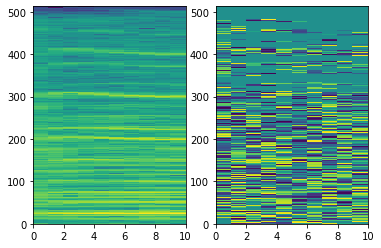

In [7]:
samples = PolySamples(num_files=10, config=config)
samples.load()
print("xs: %s, ys: %s" % (samples.mags.shape, samples.ys.shape))

example = 0
example_indices = list(range(example * samples.windows_per_file, (example * samples.windows_per_file) + samples.windows_per_file))
print(example_indices)

print(samples.files[example])
print("Tunings:", [samples.tunings[example_indices[i]] for i in range(samples.windows_per_file)])
print("Ys:", [samples.vector_to_notes(samples.ys[example_indices[i]]) for i in range(samples.windows_per_file)])

plt.subplot(1, 2, 1)
plt.pcolormesh(samples.mags[example * samples.windows_per_file])
plt.subplot(1, 2, 2)
plt.pcolormesh(samples.phases[example * samples.windows_per_file])

In [8]:
def plot_history(history):
  for k in history.history:
    vals = history.history[k]
    
    if k.endswith("loss"):
        plt.plot(vals, label=k)

  plt.legend()
  plt.figure()
    
  for k in history.history:
    vals = history.history[k]
    
    if k.endswith("accuracy"):
        plt.plot(vals, label=k)

  plt.legend()
  plt.show()

# Models

In [9]:
import re
import sys
import os

import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

## Multiheaded Model

This model has two inputs and two outputs. Magnitudes are run through a conv layer, and Phases through an RNN. Extracted features are sent to two dense layers, one emitting chords, and the other roots.

Initializing DeepSamples:PolySamples...
rows: 513, cols: 59, windows_per_file: 10
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/

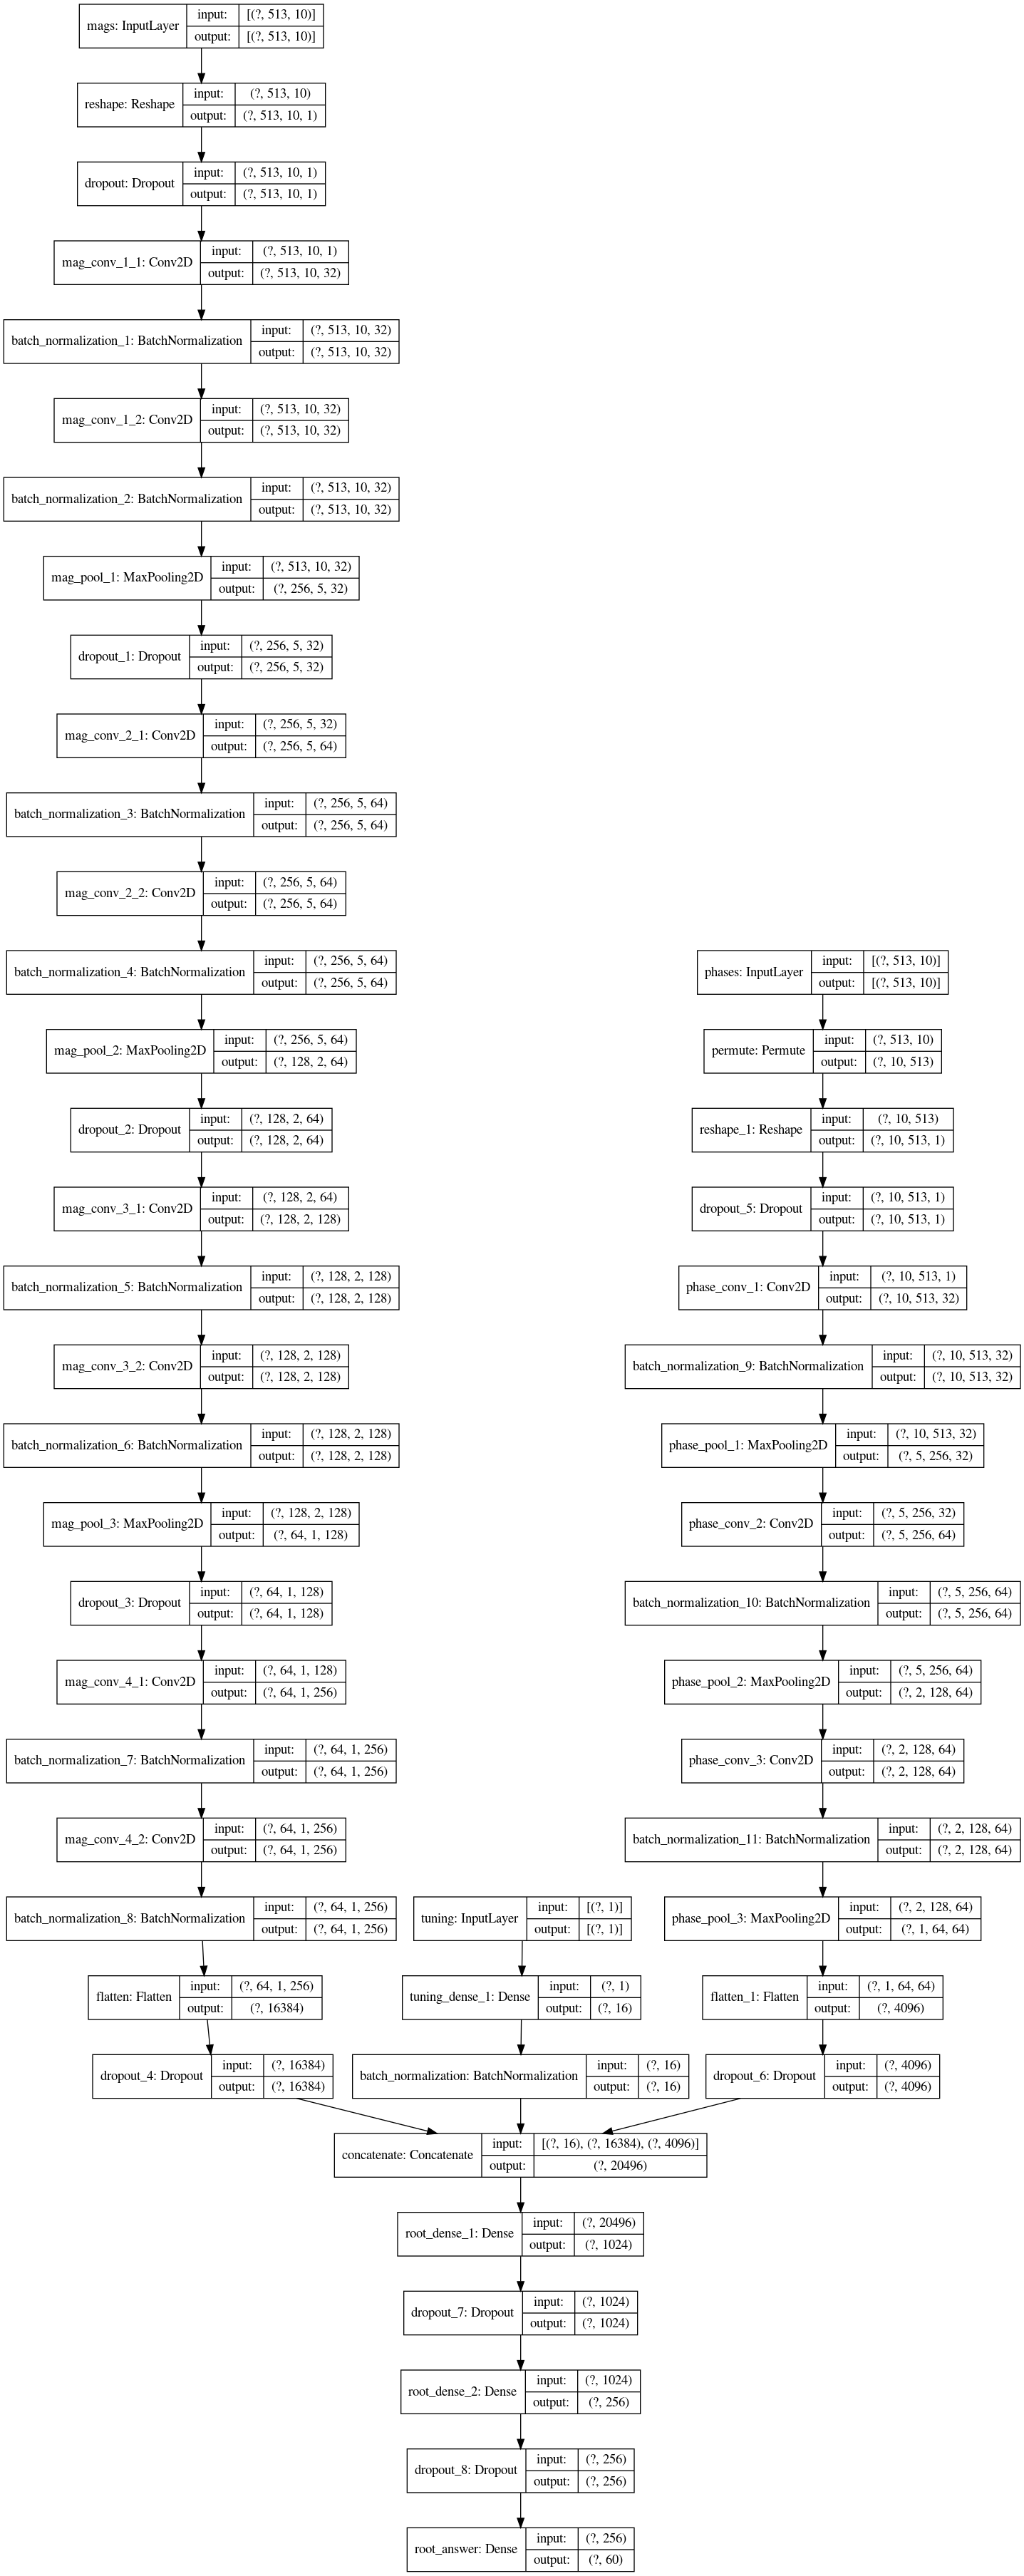

In [10]:
import tensorflow as tf
from tensorflow.keras import layers

def build_model(rows, cols, num_classes=60):
    tuning_input = layers.Input(shape=(1), name='tuning')
    mags_input = layers.Input(shape=(rows, cols), name='mags')
    phases_input = layers.Input(shape=(rows, cols), name='phases')

    tuning_layers = layers.Dense(16, activation='relu', name='tuning_dense_1')(tuning_input)
    tuning_layers = layers.BatchNormalization()(tuning_layers)

    mag_layers = layers.Reshape((rows, cols, 1))(mags_input)
    mag_layers = layers.Dropout(0.2)(mag_layers)

    mag_layers = layers.Conv2D(32, (3,3), padding="same", activation='relu', name="mag_conv_1_1")(mag_layers)
    mag_layers = layers.BatchNormalization()(mag_layers)
    mag_layers = layers.Conv2D(32, (3,3), padding="same", activation='relu', name="mag_conv_1_2")(mag_layers)
    mag_layers = layers.BatchNormalization()(mag_layers)
    mag_layers = layers.MaxPooling2D(pool_size=(2,2), name="mag_pool_1")(mag_layers)
    mag_layers = layers.Dropout(0.2)(mag_layers)

    mag_layers = layers.Conv2D(64, (3,3), padding="same", activation='relu', name="mag_conv_2_1")(mag_layers)
    mag_layers = layers.BatchNormalization()(mag_layers)
    mag_layers = layers.Conv2D(64, (3,3), padding="same", activation='relu', name="mag_conv_2_2")(mag_layers)
    mag_layers = layers.BatchNormalization()(mag_layers)
    mag_layers = layers.MaxPooling2D(pool_size=(2,2), name="mag_pool_2")(mag_layers)
    mag_layers = layers.Dropout(0.2)(mag_layers)

    mag_layers = layers.Conv2D(128, (3,3), padding="same", activation='relu', name="mag_conv_3_1")(mag_layers)
    mag_layers = layers.BatchNormalization()(mag_layers)
    mag_layers = layers.Conv2D(128, (3,3), padding="same", activation='relu', name="mag_conv_3_2")(mag_layers)
    mag_layers = layers.BatchNormalization()(mag_layers)
    mag_layers = layers.MaxPooling2D(pool_size=(2,2), name="mag_pool_3")(mag_layers)
    mag_layers = layers.Dropout(0.2)(mag_layers)

    mag_layers = layers.Conv2D(256, (3,3), padding="same", activation='relu', name="mag_conv_4_1")(mag_layers)
    mag_layers = layers.BatchNormalization()(mag_layers)
    mag_layers = layers.Conv2D(256, (3,3), padding="same", activation='relu', name="mag_conv_4_2")(mag_layers)
    mag_layers = layers.BatchNormalization()(mag_layers)
    mag_layers = layers.Flatten()(mag_layers)
    mag_layers = layers.Dropout(0.2)(mag_layers)

    phase_layers = layers.Permute((2, 1))(phases_input)
    phase_layers = layers.Reshape((cols, rows, 1))(phase_layers)
    phase_layers = layers.Dropout(0.2)(phase_layers)
    phase_layers = layers.Conv2D(32, (3,3), padding="same", activation='relu', name="phase_conv_1")(phase_layers)
    phase_layers = layers.BatchNormalization()(phase_layers)
    phase_layers = layers.MaxPooling2D(pool_size=(2,2), name="phase_pool_1")(phase_layers)
    phase_layers = layers.Conv2D(64, (3,3), padding="same", activation='relu', name="phase_conv_2")(phase_layers)
    phase_layers = layers.BatchNormalization()(phase_layers)
    phase_layers = layers.MaxPooling2D(pool_size=(2,2), name="phase_pool_2")(phase_layers)
    phase_layers = layers.Conv2D(64, (3,3), padding="same", activation='relu', name="phase_conv_3")(phase_layers)
    phase_layers = layers.BatchNormalization()(phase_layers)
    phase_layers = layers.MaxPooling2D(pool_size=(2,2), name="phase_pool_3")(phase_layers)
    phase_layers = layers.Flatten()(phase_layers)
    phase_layers = layers.Dropout(0.2)(phase_layers)

    concatenated = layers.concatenate([tuning_layers, mag_layers, phase_layers])

    root_layers = layers.Dense(1024, activation='relu', name='root_dense_1')(concatenated)
    root_layers = layers.Dropout(0.2)(root_layers)
    root_layers = layers.Dense(256, activation='relu', name='root_dense_2')(root_layers)
    root_layers = layers.Dropout(0.2)(root_layers)
    root_answer = layers.Dense(num_classes, activation='sigmoid', name='root_answer')(root_layers)

    return tf.keras.models.Model([tuning_input, mags_input, phases_input], [root_answer])


dummy_samples = PolySamples(num_files=10, config=config)
rows = dummy_samples.rows
cols = dummy_samples.cols

mirrored_strategy = tf.distribute.MirroredStrategy()
with mirrored_strategy.scope():
    model = build_model(rows, cols, num_classes=len(dummy_samples.note_classes))
    optimizer = tf.keras.optimizers.Adam(amsgrad=True)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()
plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True, )
display.display(display.Image("model.png"))

In [11]:
total_files = 4000
total_samples = total_files * dummy_samples.windows_per_file
training_samples = int(total_samples * 0.8)
print("files: %d, total_samples: %d, training_samples: %d" % (total_files, total_samples, training_samples))

prod_samples = PolySamples(num_files=total_files, config=config)
prod_samples.load()

print("mags: %s, phases: %s, tunings: %s, ys: %s" % (prod_samples.mags.shape, prod_samples.phases.shape, prod_samples.tunings.shape, prod_samples.ys.shape))

files: 4000, total_samples: 40000, training_samples: 32000
Initializing DeepSamples:PolySamples...
rows: 513, cols: 59, windows_per_file: 10
Loading sample files...
Shuffling samples...
Generating spectrograms...


[============================================================] 4000/4000

Normalizing data...
Samples ready.
mags: (40000, 513, 10), phases: (40000, 513, 10), tunings: (40000, 1), ys: (40000, 60)


In [12]:
history = model.fit([prod_samples.tunings[:training_samples], prod_samples.mags[:training_samples], prod_samples.phases[:training_samples]], [prod_samples.ys[:training_samples]], epochs=25, batch_size=64, validation_split=0.1)
plot_history(history)

Train on 25600 samples, validate on 6400 samples
Epoch 1/25
25600/25600 [==============================] - 76s 3ms/sample - loss: 0.1933 - accuracy: 0.9396 - val_loss: 0.4986 - val_accuracy: 0.9367
Epoch 2/25
25600/25600 [==============================] - 63s 2ms/sample - loss: 0.0941 - accuracy: 0.9654 - val_loss: 0.1765 - val_accuracy: 0.9469
Epoch 3/25
25600/25600 [==============================] - 63s 2ms/sample - loss: 0.0462 - accuracy: 0.9828 - val_loss: 0.1831 - val_accuracy: 0.9483
Epoch 4/25
25600/25600 [==============================] - 63s 2ms/sample - loss: 0.0261 - accuracy: 0.9905 - val_loss: 0.2094 - val_accuracy: 0.9499
Epoch 5/25
13952/25600 [===============>..............] - ETA: 27s - loss: 0.0196 - accuracy: 0.9930

KeyboardInterrupt: 

In [ ]:
predictions = model.predict([prod_samples.tunings[training_samples:], prod_samples.mags[training_samples:], prod_samples.phases[training_samples:]])
predictions[predictions>=0.3] = 1
predictions[predictions<0.3] = 0
labels = prod_samples.ys[training_samples:]

# y_predictions = np.argmax(predictions, axis=-1)
# plt.matshow(tf.math.confusion_matrix(y_predictions, labels))

In [104]:
for i in range(10, 20):
    print(prod_samples.vector_to_notes(predictions[i]), prod_samples.vector_to_notes(labels[i]))


['E2', 'B2', 'Gs3'] ['Fs2', 'Cs3', 'B3', 'Gs4']
['B6'] ['Fs2', 'Cs3', 'B3', 'Gs4']
['F3', 'G3', 'B6'] ['Fs2', 'Cs3', 'B3', 'Gs4']
['E2'] ['Fs2', 'Cs3', 'B3', 'Gs4']
['B2', 'Cs3'] ['Fs2', 'Cs3', 'B3', 'Gs4']
['Cs2', 'E2', 'B2', 'Cs3'] ['Fs2', 'Cs3', 'B3', 'Gs4']
['Cs2', 'E2', 'B2', 'Cs3'] ['Fs2', 'Cs3', 'B3', 'Gs4']
['B2', 'Cs3', 'Gs3'] ['Fs2', 'Cs3', 'B3', 'Gs4']
['E2', 'B2', 'Cs3', 'Gs3'] ['Fs2', 'Cs3', 'B3', 'Gs4']
['B2'] ['Fs2', 'Cs3', 'B3', 'Gs4']


(1, 513, 10, 32)


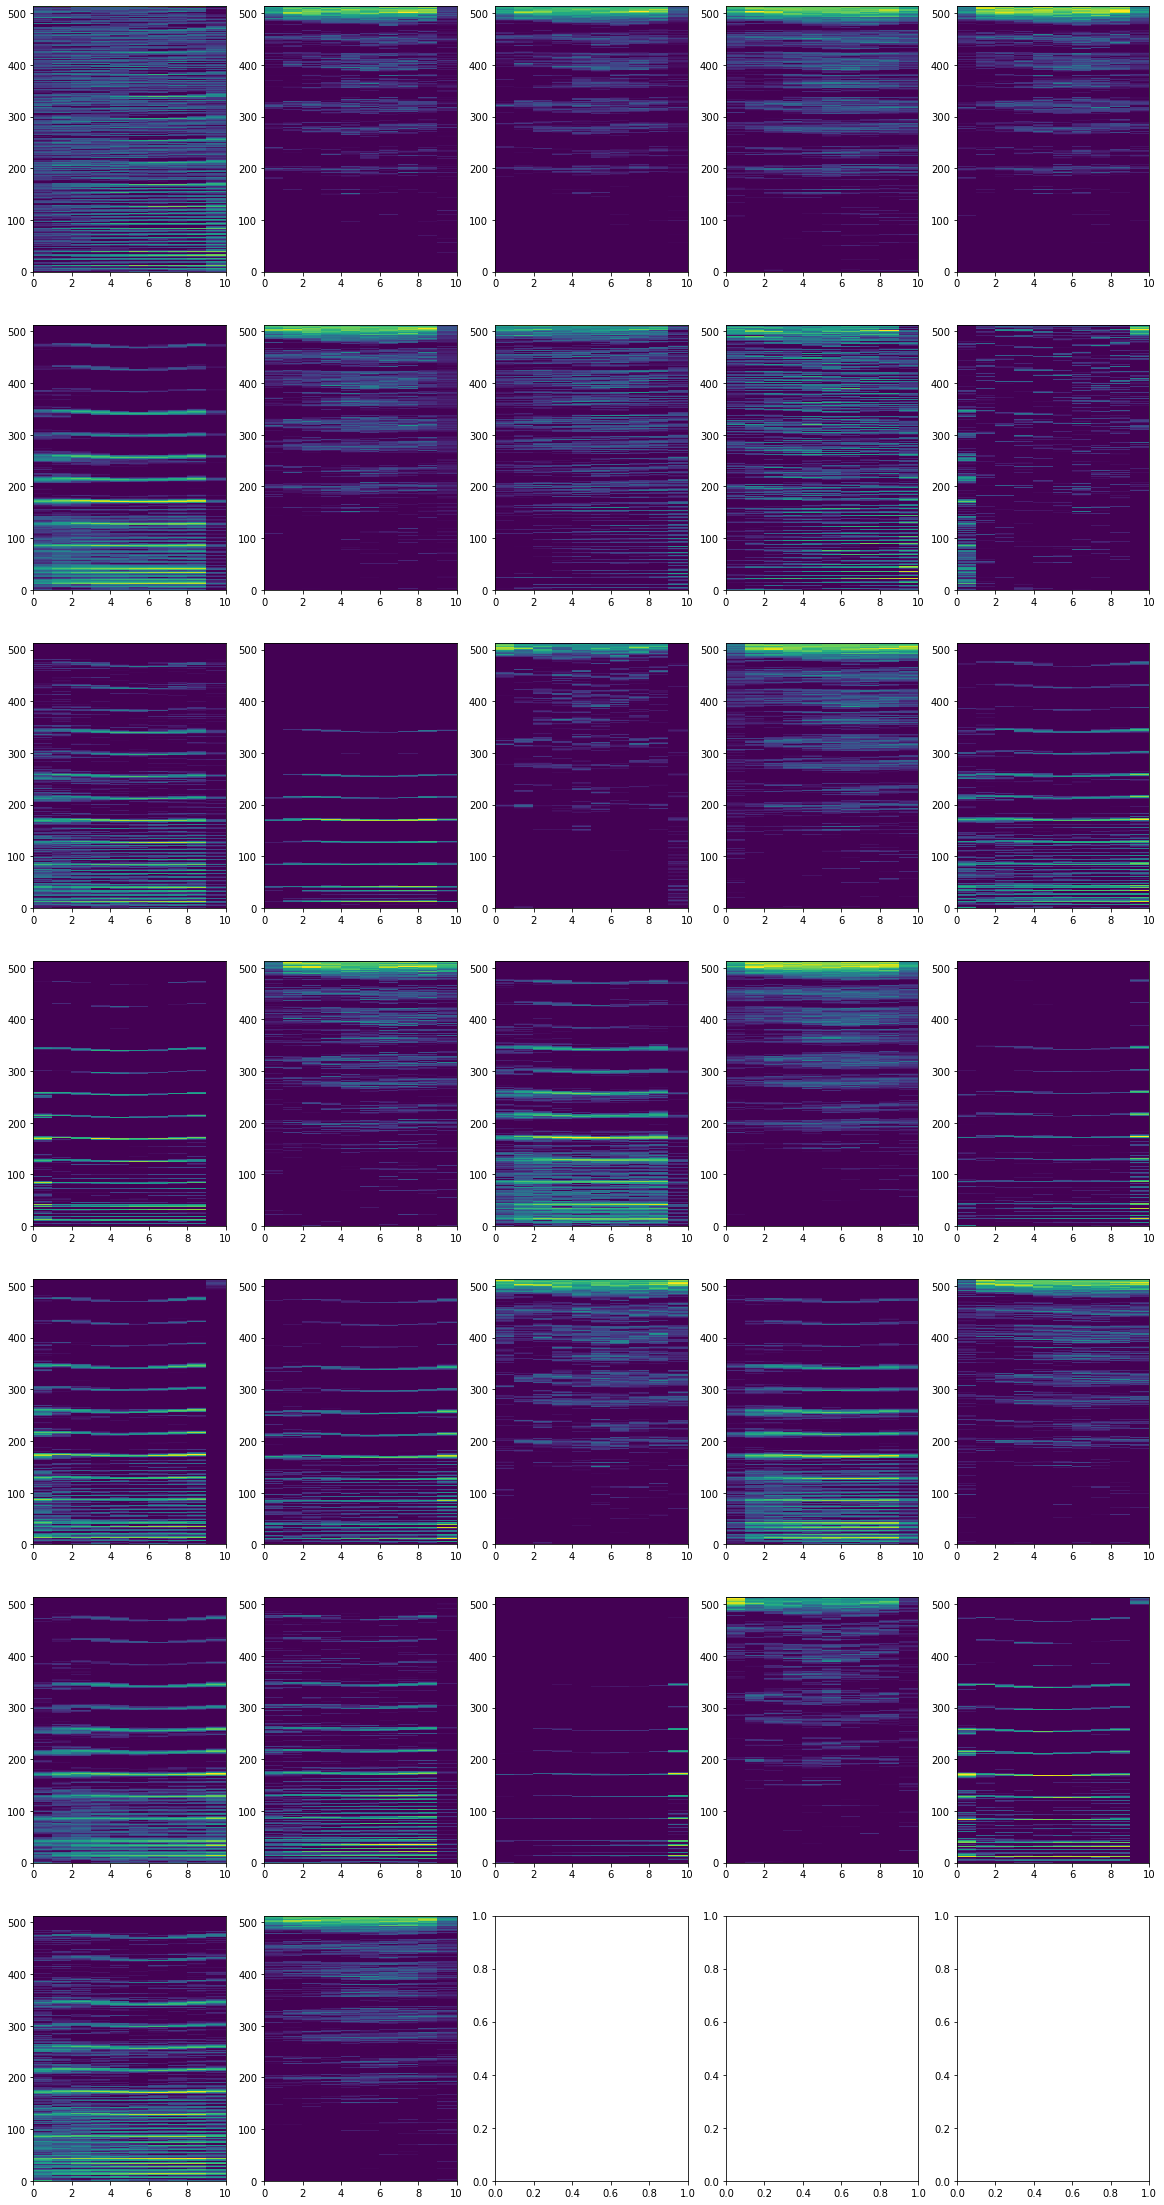

In [85]:
def visualize_filters(layer_num, count, x, model=model):
  layer = model.get_layer(index=layer_num)
  layer_output=layer.output
  
  intermediate_model=tf.keras.models.Model(inputs=model.inputs,outputs=layer_output)
  intermediate_prediction=intermediate_model.predict(x)

  col_size=5
  row_size=int(count / col_size) + 1
  
  print(np.shape(intermediate_prediction))
  fig,ax=plt.subplots(row_size,col_size,figsize=(20,40))

  img_index=0
  row=0
  col=0
  while img_index < count:
    ax[row][col].pcolormesh(intermediate_prediction[0, :, :, img_index])
    img_index=img_index+1
    col += 1
    if col >= col_size:
      col = 0
      row +=1
    if img_index > count: break

visualize_filters(6, 32, x=[prod_samples.tunings[0], prod_samples.mags[0].reshape(1, rows, cols), prod_samples.phases[0].reshape(1, rows, cols)])

mags: 10 (1, 513, 10)
phases: 10 (1, 513, 10)
reshape_3: 1 (1, 513, 10, 1)
permute_1: 513 (1, 10, 513)
dropout_10: 1 (1, 513, 10, 1)
reshape_4: 1 (1, 10, 513, 1)
mag_conv_1: 32 (1, 513, 10, 32)
dropout_13: 1 (1, 10, 513, 1)
batch_normalization_9: 32 (1, 513, 10, 32)
phase_conv_1: 32 (1, 10, 513, 32)
mag_pool_1: 32 (1, 256, 5, 32)
batch_normalization_12: 32 (1, 10, 513, 32)
dropout_11: 32 (1, 256, 5, 32)
phase_pool_1: 32 (1, 5, 256, 32)
mag_conv_2: 64 (1, 256, 5, 64)
phase_conv_2: 64 (1, 5, 256, 64)
batch_normalization_10: 64 (1, 256, 5, 64)
batch_normalization_13: 64 (1, 5, 256, 64)
mag_pool_2: 64 (1, 128, 2, 64)
phase_pool_2: 64 (1, 2, 128, 64)
mag_conv_3: 128 (1, 128, 2, 128)
phase_conv_3: 128 (1, 2, 128, 128)
batch_normalization_11: 128 (1, 128, 2, 128)
batch_normalization_14: 128 (1, 2, 128, 128)
tuning: 1 (1, 1)
mag_pool_3: 128 (1, 64, 1, 128)
phase_pool_3: 128 (1, 1, 64, 128)
tuning_dense_1: 64 (1, 64)
flatten_2: 8192 (1, 8192)
flatten_3: 8192 (1, 8192)
batch_normalization_8: 64 

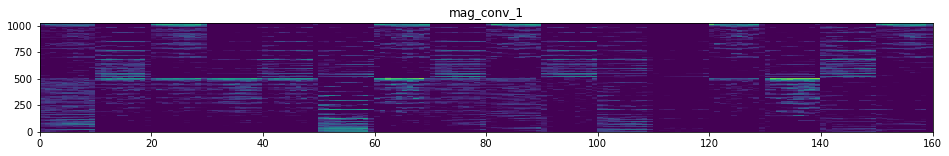

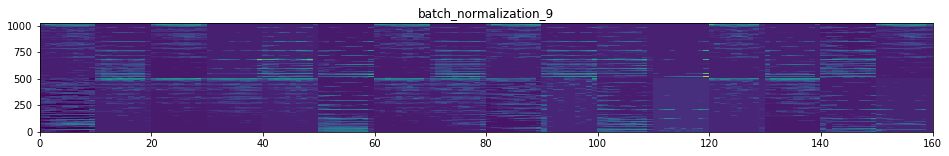

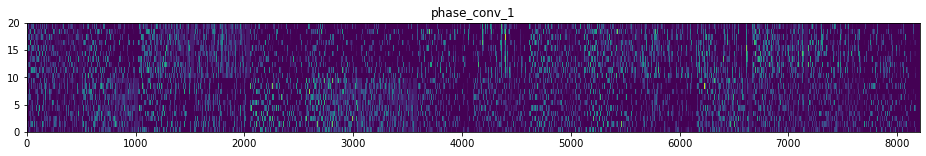

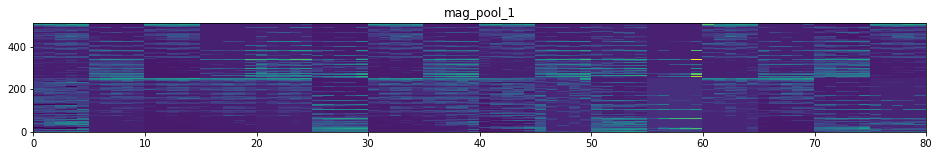

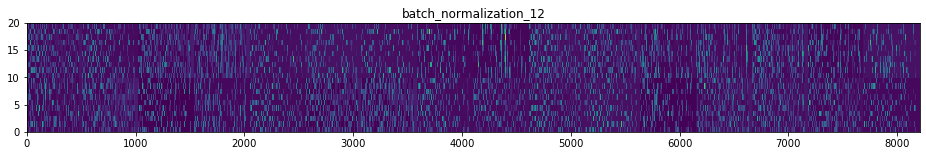

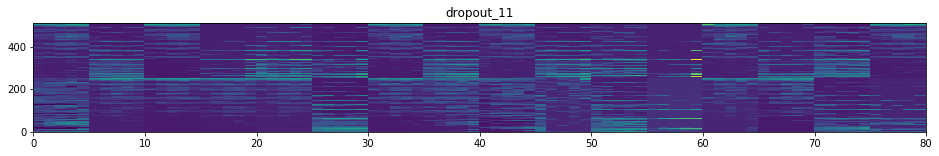

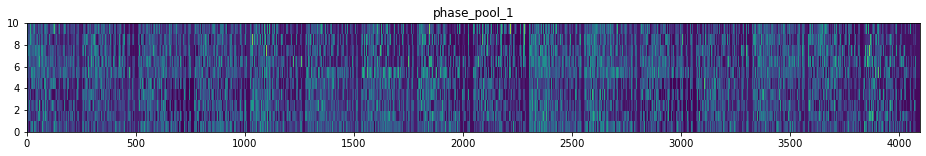

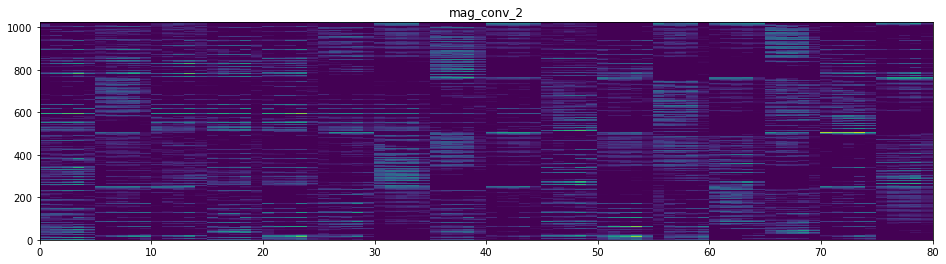

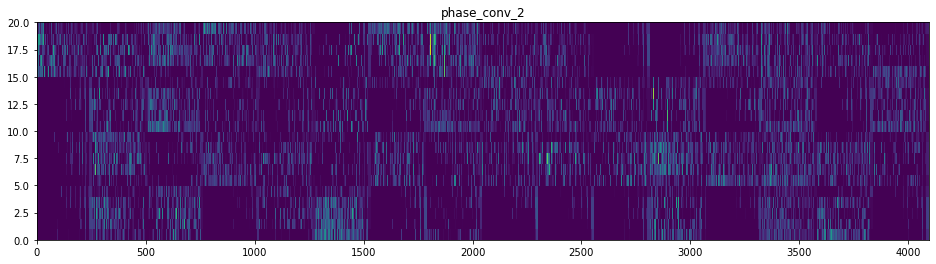

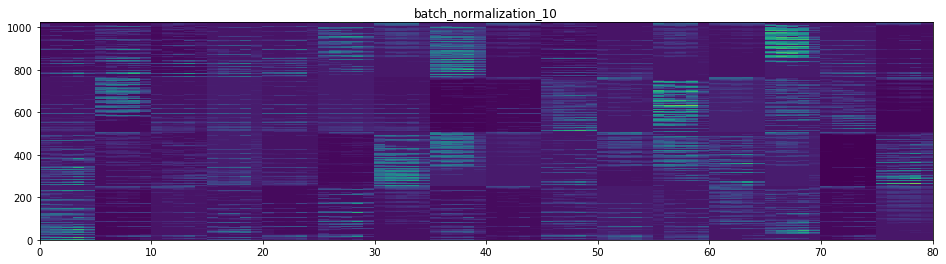

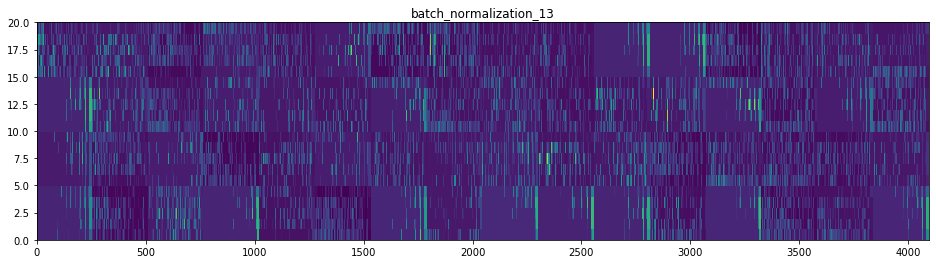

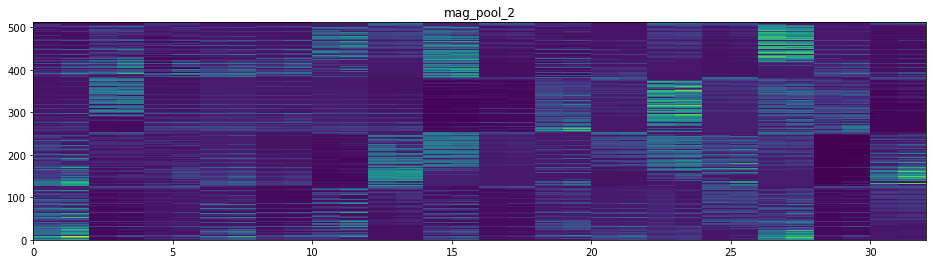

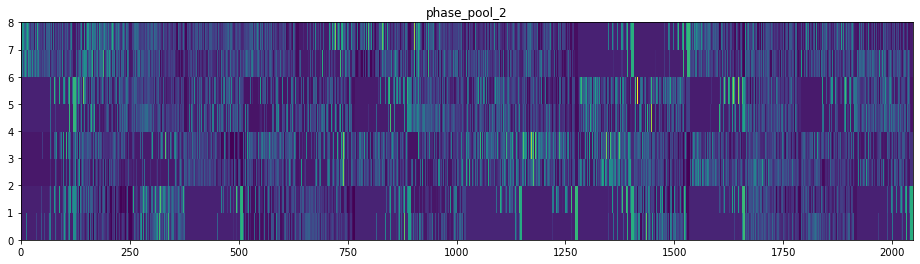

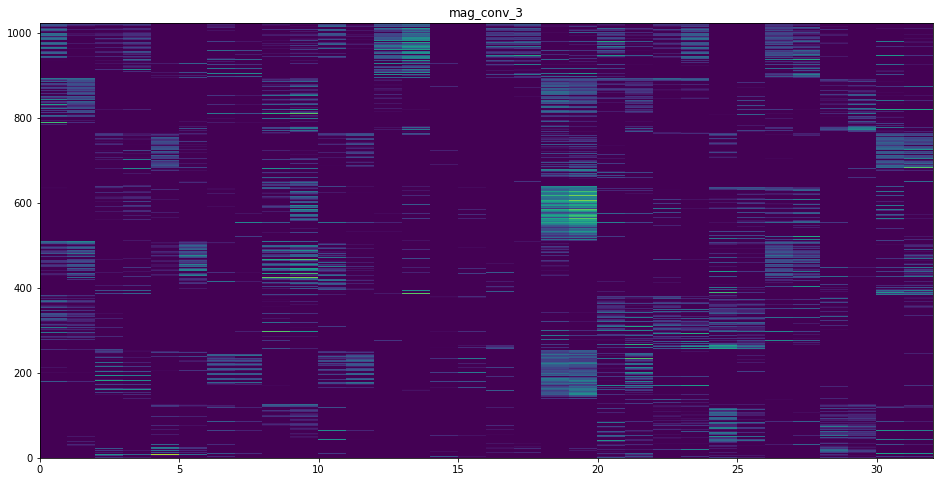

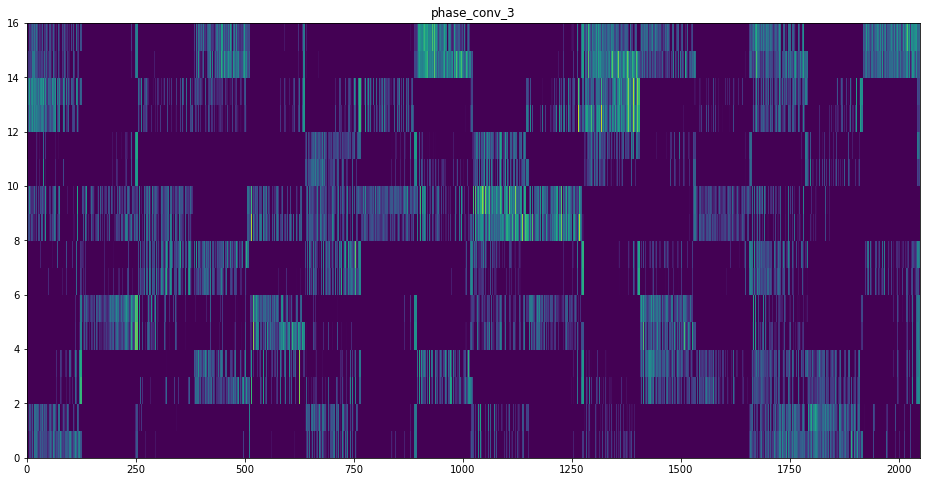

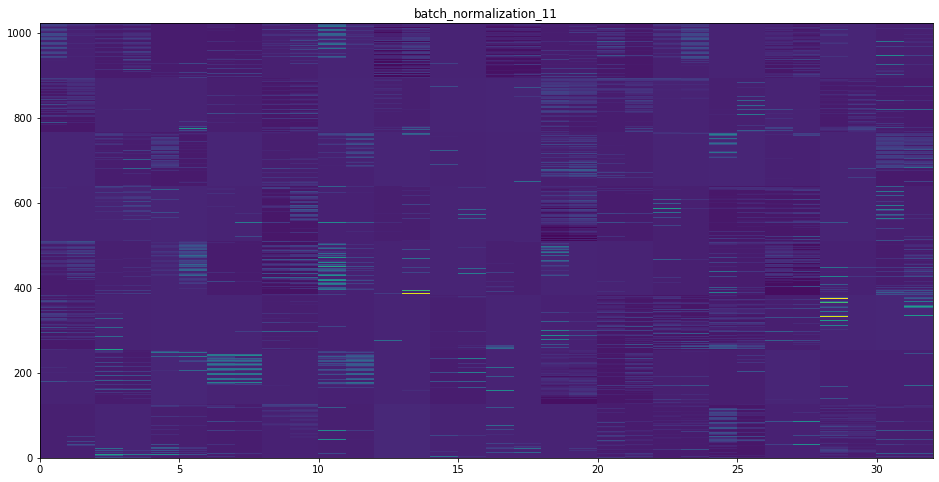

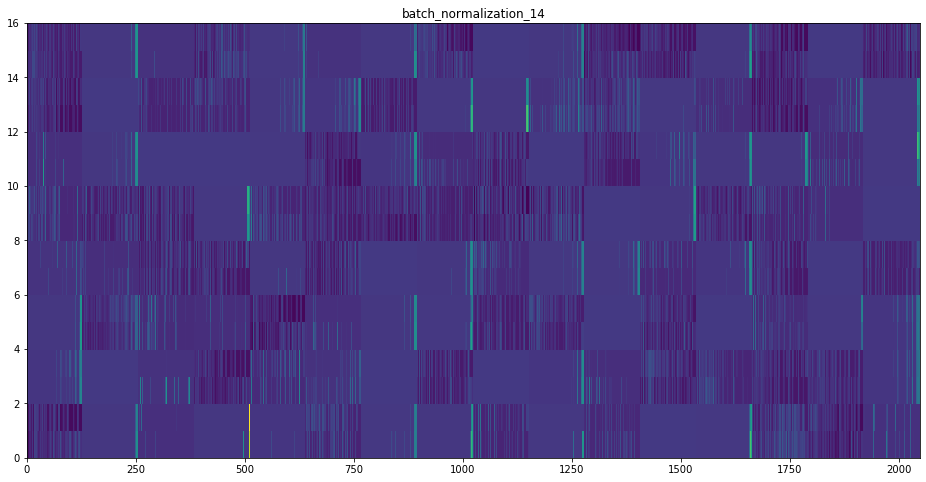

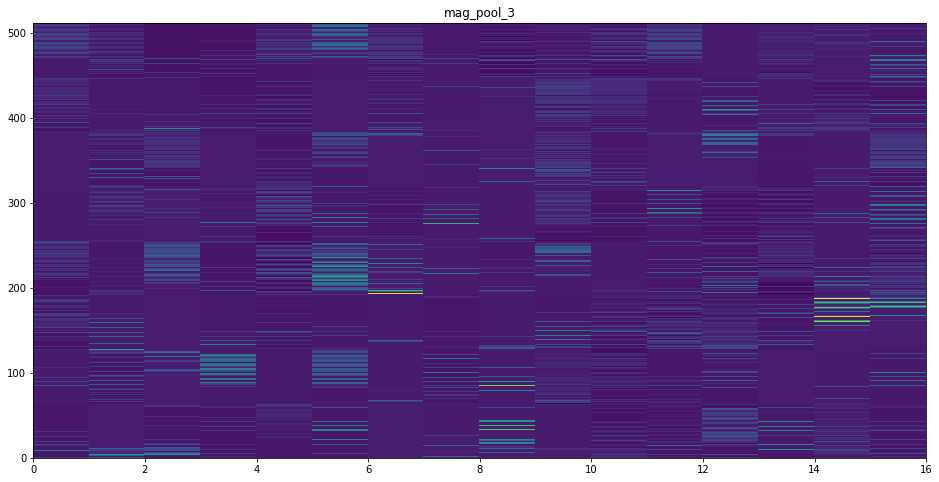

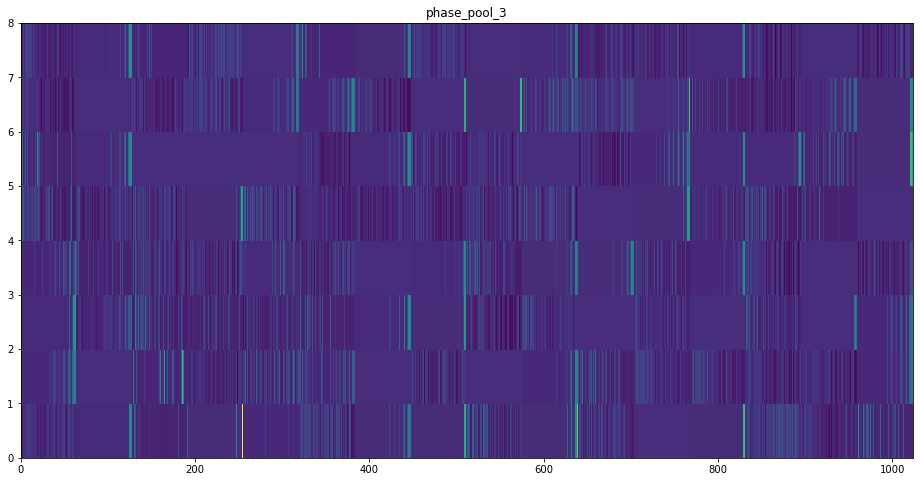

In [86]:
from keras import models

layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.compat.v1.keras.Model(inputs=model.inputs, outputs=layer_outputs)

activations = activation_model.predict([prod_samples.tunings[0], prod_samples.mags[0].reshape(1, rows, cols), prod_samples.phases[0].reshape(1, rows, cols)]) 

layer_names = []
for layer in model.layers:
  layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
  n_features = layer_activation.shape[-1]
  n_cols = n_features // images_per_row
  print("%s:" % layer_name, n_features, layer_activation.shape)
  if len(layer_activation.shape) < 4:
    continue

  if n_cols == 0:
    continue

  col_size = layer_activation.shape[1]
  row_size = layer_activation.shape[2]

  display_grid = np.zeros((col_size * n_cols, images_per_row * row_size))

  for col in range(n_cols):
      for row in range(images_per_row):
          channel_image = layer_activation[0, :, :, col * images_per_row + row]
          display_grid[col * col_size : (col + 1) * col_size, row * row_size : (row + 1) * row_size] = channel_image
    
  col_scale =1. / col_size
  row_scale =1. / row_size

  plt.figure(figsize=(row_scale * display_grid.shape[1], col_scale * display_grid.shape[0]))
  
  plt.title(layer_name)
  plt.grid(False)
  plt.pcolormesh(display_grid)

# Save Models

In [ ]:
# Auth this runtime to GCP (once only)
from google.colab import auth
auth.authenticate_user()

In [121]:
model.save("deepchords_model_v1.h5")
!ls -lh *.h5

-rw-r--r-- 1 jupyter jupyter 365M Mar 16 18:54 deepchords_model_v1.h5


In [122]:
!gsutil -m cp -a public-read *.h5 gs://muthanna.com/deepears

Copying file://deepchords_model_v1.h5 [Content-Type=application/octet-stream]...
\ [1/1 files][364.4 MiB/364.4 MiB] 100% Done                                    
Operation completed over 1 objects/364.4 MiB.                                    


In [127]:
old_model = model
new_model = tf.keras.models.load_model("deepchords_model_v1.h5")

In [128]:
model = new_model

# Live Test

In [124]:
!wget --no-check-certificate https://muthanna.com/deepears/sweetchild.wav

--2020-03-16 18:55:34--  https://muthanna.com/deepears/sweetchild.wav
Resolving muthanna.com (muthanna.com)... 35.244.227.152
Connecting to muthanna.com (muthanna.com)|35.244.227.152|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2020-03-16 18:55:35 ERROR 404: Not Found.



In [ ]:
fs, data = wavfile.read('sweetchild-8bit.wav')
sample_len = int(8000 * 0.33) # 0.33ms slice of 8khz audio
num_samples = int(len(data) / sample_len)
remainder = len(data) % sample_len

samples = np.reshape(data[0:len(data) - remainder], (num_samples, sample_len))

In [ ]:
for i in range(0, num_samples):
  f, t, Sxx = signal.spectrogram(samples[i], fs, window=('hann'), nperseg=64, nfft=128, noverlap=16, mode='magnitude')
  Sxx = Sxx.reshape(1, 65, 54,1)
  root_class = deepears.root_model.predict_classes(Sxx)
  chord_class = deepears.chord_model.predict_classes(Sxx)
  
  chord = deepears.get_chord_classes()[int(chord_class)]
  root = deepears.get_root_classes()[int(root_class)]
  print(i * 0.33, "seconds:", root, chord)


0.0 seconds: Cs min7
0.33 seconds: Cs dom7
0.66 seconds: D dom7
0.99 seconds: As dom7
1.32 seconds: D dom7
1.6500000000000001 seconds: Fs dom7
1.98 seconds: Cs dom7
2.31 seconds: Fs min7
2.64 seconds: E maj7
2.97 seconds: D dom7
3.3000000000000003 seconds: F major
3.6300000000000003 seconds: D maj7
3.96 seconds: Cs min7
4.29 seconds: Fs sus2
4.62 seconds: Ds dom7
4.95 seconds: Ds dom7
5.28 seconds: Ds min7
5.61 seconds: Fs dom7
5.94 seconds: D dom7
6.2700000000000005 seconds: Cs dom7
6.6000000000000005 seconds: Cs dom7
6.930000000000001 seconds: D min7
7.260000000000001 seconds: Cs dom7
7.590000000000001 seconds: D dom7
7.92 seconds: Fs dom7
8.25 seconds: D dom7
8.58 seconds: G min7
8.91 seconds: Fs minor
9.24 seconds: D dom7
9.57 seconds: D dom7
9.9 seconds: B min7
10.23 seconds: Ds dom7
10.56 seconds: Fs dom7
10.89 seconds: Fs dom7
11.22 seconds: Cs dom7
11.55 seconds: C dom7
11.88 seconds: B maj7
12.21 seconds: Cs dom7
12.540000000000001 seconds: As dom7
12.870000000000001 seconds: 